### Data

Data Link: https://www.cryptodatadownload.com/data/

### About our data

Dataset contains the bitcoin price info per minute.

The info we interested in, is the close column. 

Close is the price of BTC at this moment.
Volume is the ammount of BTC which bought or sold at this moment.
Open price is the price which open the data in this one minute, the low
price is the lowest price which reach at that moment and the high price is
the highest price which reach at that moment.

### Download Data

In [1]:
# !pip install --upgrade --no-cache-dir gdown
# !gdown --id 1KPEqhAGgvikASZhEeH48qzApKMy60iZ_

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.preprocessing import MinMaxScaler
import random
import time
import copy
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import tensorflow as tf
%matplotlib inline

In [3]:
# size of dataframe
ROWS_OF_DATASET = 1440 * 10
#### LSTM ###
# size of test data 
TEST_DATA_LSTM = 1440 * 1
# size of input in lstm
LOOK_BACK_LSTM = 10
# size of lstm units
LSTM_UNITS = 32
# percentage of train data that will be our validation data
VALIDATION_DATA = 0.2
# how many days we want to forecast
FORECASTING_MINUTES = 720 
### RRL ###
# we want train data end in the same spot with lstm data
TRAIN_DATA_RRL = ROWS_OF_DATASET - TEST_DATA_LSTM
LOOK_BACK_RRL = LOOK_BACK_LSTM
EPOCHS_RRL = 1000
LEARNING_RATE_RRL = 0.5

## Import data

In [4]:
btc_input_df  = pd.read_csv("BTC-USD.csv", parse_dates=["time"], nrows=ROWS_OF_DATASET)
btc_input_df.head()

,time,low,high,open,close,volume
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128


In [5]:
btc_input_df = btc_input_df.set_index('time')
btc_input_df.head()

,low,high,open,close,volume
time,,,,,
2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079
2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128


In [6]:
btc_input_df = btc_input_df.sort_index()
btc_input_df.head()

,low,high,open,close,volume
time,,,,,
2021-10-20 03:01:00,63816.52,63860.23,63839.44,63823.36,2.736049
2021-10-20 03:02:00,63812.47,63835.33,63823.36,63827.88,3.145124
2021-10-20 03:03:00,63810.00,63837.24,63827.56,63810.01,6.178755
2021-10-20 03:04:00,63792.27,63823.50,63810.00,63817.06,4.367886
2021-10-20 03:05:00,63806.39,63849.85,63813.21,63847.04,6.441521


In [7]:
print(btc_input_df.shape)
print("------------------------")
print(btc_input_df.info())

(14400, 5)
------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14400 entries, 2021-10-20 03:01:00 to 2021-10-30 03:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   low     14400 non-null  float64
 1   high    14400 non-null  float64
 2   open    14400 non-null  float64
 3   close   14400 non-null  float64
 4   volume  14400 non-null  float64
dtypes: float64(5)
memory usage: 675.0 KB
None


In [8]:
btc_input_df.head()

,low,high,open,close,volume
time,,,,,
2021-10-20 03:01:00,63816.52,63860.23,63839.44,63823.36,2.736049
2021-10-20 03:02:00,63812.47,63835.33,63823.36,63827.88,3.145124
2021-10-20 03:03:00,63810.00,63837.24,63827.56,63810.01,6.178755
2021-10-20 03:04:00,63792.27,63823.50,63810.00,63817.06,4.367886
2021-10-20 03:05:00,63806.39,63849.85,63813.21,63847.04,6.441521


In [9]:
btc_input_df.tail()

,low,high,open,close,volume
time,,,,,
2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128
2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079


## Plot informations

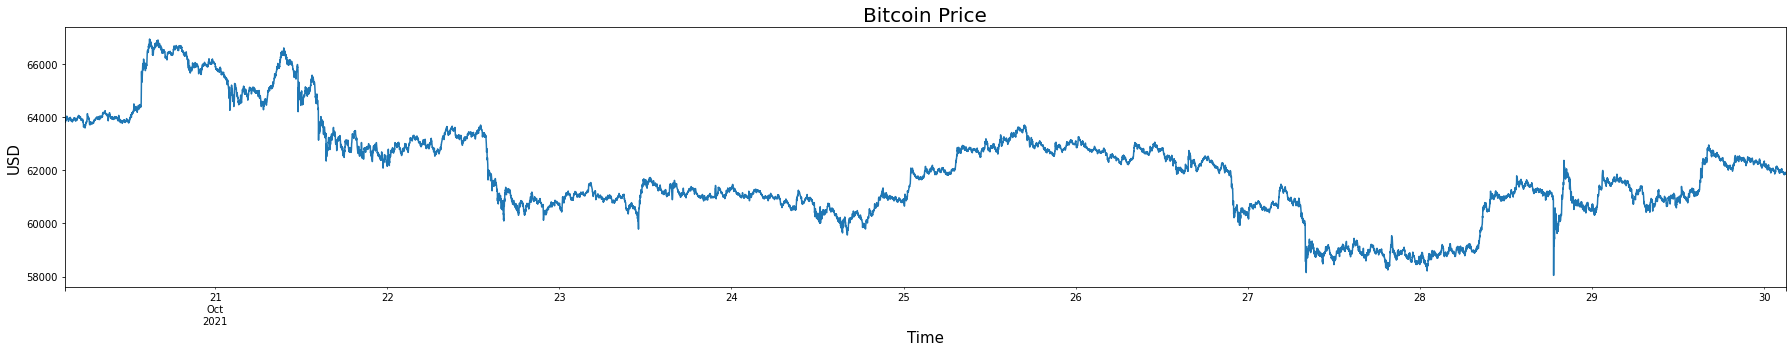

In [10]:
plt.figure(figsize=(20,5))
plt.title("Bitcoin Price", fontsize=20)
btc_input_df.close.plot(figsize=(25,5))
plt.xlabel("Time", fontsize=15)
plt.ylabel("USD", fontsize=15)
plt.tight_layout()

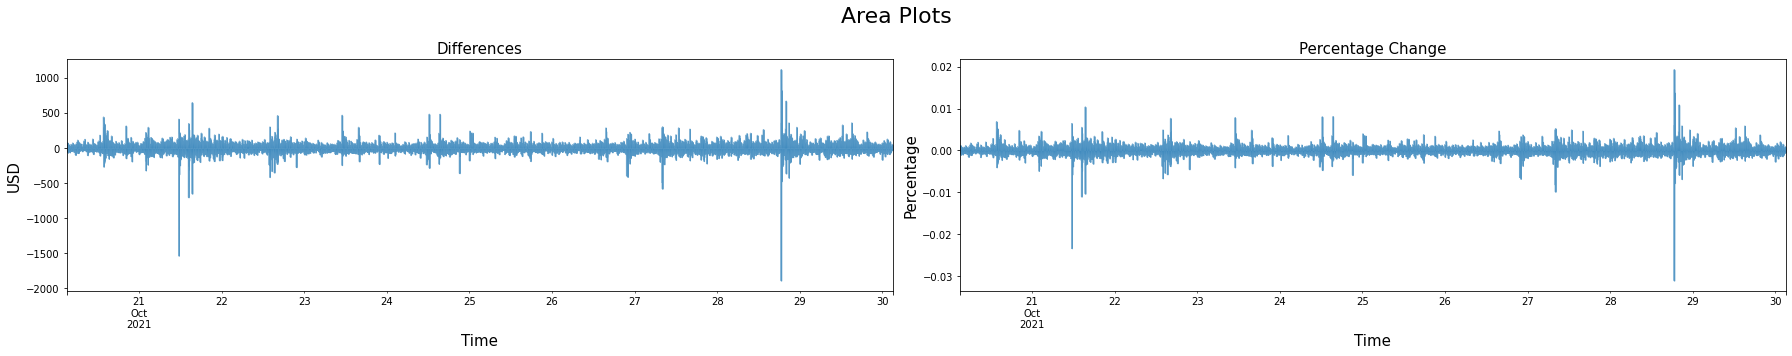

In [11]:
plt.figure(figsize=(25,5))
plt.suptitle('Area Plots', fontsize=22)

plt.subplot(1,2,1)
btc_input_df.close.diff().plot.area(stacked=False,)
plt.ylabel("USD", fontsize="15")
plt.xlabel("Time", fontsize="15")
plt.title("Differences", fontsize="15")

plt.subplot(1,2,2)
btc_input_df.close.pct_change().plot.area(stacked=False,)
plt.ylabel("Percentage", fontsize="15")
plt.xlabel("Time", fontsize="15")
plt.title("Percentage Change", fontsize="15")

plt.tight_layout()

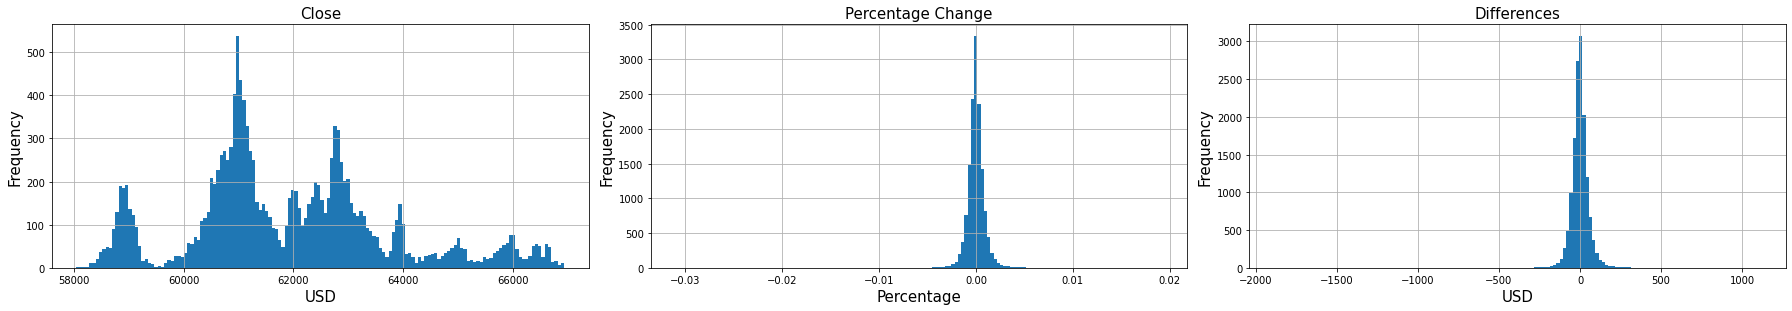

In [12]:
plt.figure(figsize=(25,12))

plt.subplot(3,3,1)
btc_input_df.close.hist(bins=150)
plt.xlabel("USD", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title('Close', fontsize=15)

plt.subplot(3,3,2)
btc_input_df.close.pct_change().hist(bins=150)
plt.xlabel("Percentage", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title('Percentage Change', fontsize=15)

plt.subplot(3,3,3)
btc_input_df.close.diff().hist(bins=150)
plt.xlabel("USD", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title('Differences', fontsize=15)

plt.tight_layout()

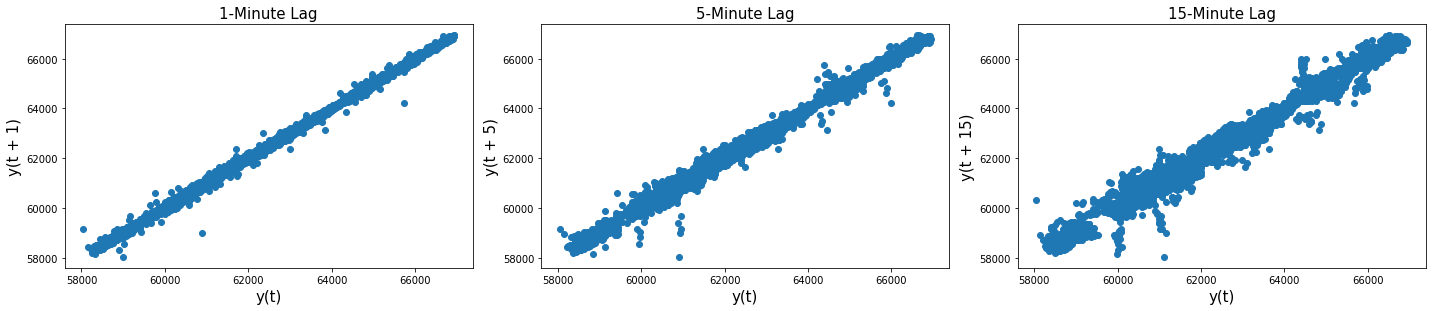

In [13]:
# κάνουμε plot το corelation 
plt.figure(figsize=(20,12))

plt.subplot(3,3,1)
pd.plotting.lag_plot(btc_input_df['close'], lag=1) #minute lag
plt.xlabel("y(t)", fontsize=15)
plt.ylabel("y(t + 1)", fontsize=15)
plt.title('1-Minute Lag', fontsize=15)

plt.subplot(3,3,2)
pd.plotting.lag_plot(btc_input_df['close'], lag=5) 
plt.xlabel("y(t)", fontsize=15)
plt.ylabel("y(t + 5)", fontsize=15)
plt.title('5-Minute Lag', fontsize=15)

plt.subplot(3,3,3)
pd.plotting.lag_plot(btc_input_df['close'], lag=15) 
plt.xlabel("y(t)", fontsize=15)
plt.ylabel("y(t + 15)", fontsize=15)
plt.title('15-Minute Lag', fontsize=15)

plt.tight_layout()

## Pre processing data for LSTM model

In [14]:
btc_closing_price = btc_input_df['close'].copy()
btc_closing_price.head()

time
2021-10-20 03:01:00    63823.36
2021-10-20 03:02:00    63827.88
2021-10-20 03:03:00    63810.01
2021-10-20 03:04:00    63817.06
2021-10-20 03:05:00    63847.04
Name: close, dtype: float64

In [15]:
df_train= btc_closing_price[:-TEST_DATA_LSTM].copy()
df_test= btc_closing_price[-TEST_DATA_LSTM:].copy()

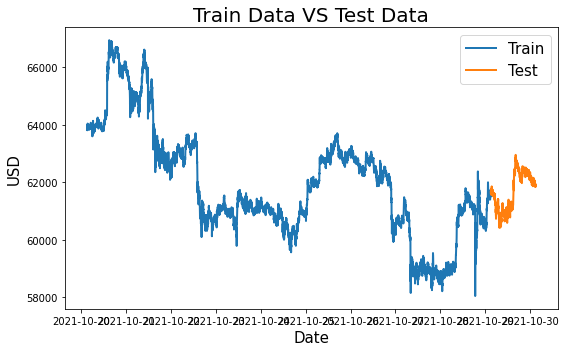

In [16]:
plt.figure(figsize=(8,5))
plt.plot(df_train, label='Train', linewidth=2, )
plt.plot(df_test, label='Test', linewidth=2)
plt.xlabel("Date", fontsize=15)
plt.ylabel('USD', fontsize=15)
plt.title('Train Data VS Test Data', fontsize=20)
plt.legend(loc='best', fontsize=15)
plt.tight_layout()

In [17]:
df_train= df_train.values.reshape(df_train.shape[0],1)
df_test= df_test.values.reshape(df_test.shape[0],1)

In [18]:
df_train.shape

(12960, 1)

In [19]:
scaler_train = MinMaxScaler(feature_range=(-1, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(-1, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [20]:
def dataset_generator_lstm(dataset, look_back=10):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):   
        window_size_x = dataset[i:(i + look_back)]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back])
        
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train, look_back= LOOK_BACK_LSTM)
testX, testY = dataset_generator_lstm(scaled_test, look_back= LOOK_BACK_LSTM)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testΧ: ", testX.shape)
print("testY", testY.shape)

trainX:  (12950, 10, 1)
trainY:  (12950, 1)
testΧ:  (1430, 10, 1)
testY (1430, 1)


Για το LSTM πρέπει να αναδιαμορφώσoyme την είσοδο ώστε να είναι ένας τρισδιάστατος πίνακας 
[δείγματα , χρονικά βήματα, χαρακτηριστικά]
Δείγματα (Samples): Είναι το len(trainX) , δηλαδή η ποσότητα των data points που έχουμε
Χαρακτηριστικά (Features): Η ποσότητα των χαρακτηριστικών σε κάθε timestep. Στην συγκεκριμένη περίπτωση το χαρακτηριστικό που έχουμε είναι η τιμή του bitcoin.  

In [21]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (12950, 10, 1)
Shape of testX:  (1430, 10, 1)


## Create LSTM model

In [22]:
model = Sequential()

model.add(LSTM(units=LSTM_UNITS, activation ='tanh', return_sequences=False, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

# model.add(LSTM(units = 64, activation = 'tanh', return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 32, activation = 'tanh', return_sequences=False, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 64, activation = 'tanh', return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 64, activation = 'tanh',return_sequences=False,input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
checkpoint_path = f'./models/btc_model_{int(time.time())}.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=10 , restore_best_weights=True)
callbacks = [checkpoint, earlystopping]
history = model.fit(trainX, trainY, batch_size = 64, epochs = 100, 
                    verbose=1, shuffle=False, 
                    validation_split=VALIDATION_DATA, callbacks=callbacks)

Epoch 1/100
155/162 [===========================>..] - ETA: 0s - loss: 0.0624
Epoch 00001: val_loss improved from inf to 0.03157, saving model to ./models\btc_model_1649178217.hdf5
162/162 [==============================] - 3s 7ms/step - loss: 0.0602 - val_loss: 0.0316
Epoch 2/100
156/162 [===========================>..] - ETA: 0s - loss: 0.0033
Epoch 00002: val_loss improved from 0.03157 to 0.00826, saving model to ./models\btc_model_1649178217.hdf5
162/162 [==============================] - 1s 4ms/step - loss: 0.0033 - val_loss: 0.0083
Epoch 3/100
155/162 [===========================>..] - ETA: 0s - loss: 0.0029
Epoch 00003: val_loss improved from 0.00826 to 0.00612, saving model to ./models\btc_model_1649178217.hdf5
162/162 [==============================] - 1s 4ms/step - loss: 0.0028 - val_loss: 0.0061
Epoch 4/100
156/162 [===========================>..] - ETA: 0s - loss: 0.0028
Epoch 00004: val_loss improved from 0.00612 to 0.00523, saving model to ./models\btc_model_1649178217.hd

In [24]:
model_from_saved_checkpoint = load_model(checkpoint_path)

## How good is our model?

Text(0.5, 1.0, 'Model Performance')

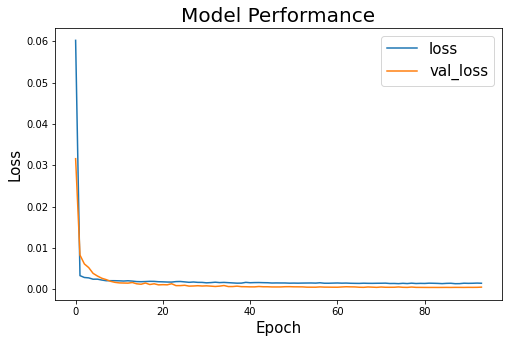

In [25]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best', fontsize=15)
plt.xlabel("Epoch",fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.title("Model Performance", fontsize=20)

In [26]:
# Τα μετατρέπουμε στην κανονική τους μορφή και κάνουμε τις προβλέψεις
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(testX.shape[0], 1))
test_actual = scaler_test.inverse_transform(testY.reshape(testX.shape[0], 1))

def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

print(f"Mean Absolute Error: {mean_absolute_error(predicted_btc_price_test_data, test_actual)}")
print(f"Mean Square Error: {mean_squared_error(predicted_btc_price_test_data, test_actual)}")
print(f"r2 score: {r2_score(predicted_btc_price_test_data, test_actual)}")
print(f"Root Mean Square Error: {rmse(predicted_btc_price_test_data, test_actual)}")

Mean Absolute Error: 45.87970093968532
Mean Square Error: 3662.8191498433994
r2 score: 0.9909145037101272
Root Mean Square Error: 60.521228918813264


In [27]:
# Τα μετατρέπουμε στην κανονική τους μορφή και κάνουμε τις προβλέψεις
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(trainX.shape[0], 1))
train_actual = scaler_train.inverse_transform(trainY.reshape(trainY.shape[0], 1))

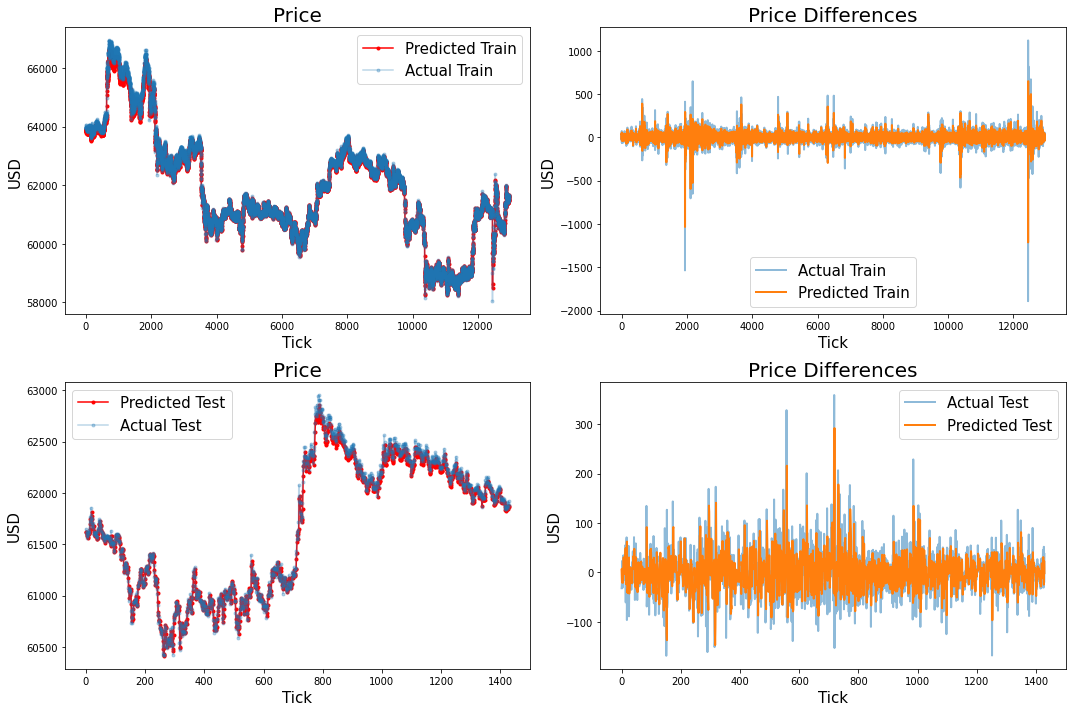

In [28]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')
plt.plot(train_actual, marker='.', label='Actual Train', alpha=0.3)
plt.xlabel("Tick", fontsize=15)
plt.ylabel("USD", fontsize=15)
plt.title("Price", fontsize=20)
plt.legend(loc='best', fontsize='15')

plt.subplot(2,2,2)
plt.plot(np.diff(train_actual, axis=0),label='Actual Train', alpha=0.5, linewidth=2)
plt.plot(np.diff(predicted_btc_price_train_data, axis=0), label='Predicted Train', linewidth=2)
plt.xlabel("Tick", fontsize=15)
plt.ylabel("USD", fontsize=15)
plt.title("Price Differences", fontsize=20)
plt.legend(loc='best', fontsize='15')
plt.tight_layout()

plt.subplot(2,2,3)
plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test', alpha=0.3)
plt.xlabel("Tick", fontsize=15)
plt.ylabel("USD", fontsize=15)
plt.title("Price", fontsize=20)
plt.legend(loc='best', fontsize='15')

plt.subplot(2,2,4)
plt.plot(np.diff(test_actual, axis=0),label='Actual Test', alpha=0.5, linewidth=2)
plt.plot(np.diff(predicted_btc_price_test_data, axis=0), label='Predicted Test', linewidth=2)
plt.xlabel("Tick", fontsize=15)
plt.ylabel("USD", fontsize=15)
plt.title("Price Differences", fontsize=20)
plt.legend(loc='best', fontsize='15')
plt.tight_layout()

## Forecasting

In [29]:
lookback_period = 720
testX_last_days = testX[testX.shape[0] - lookback_period:]
print(testX_last_days.shape)
predicted_days_forecast_price_test_x = []

for i in range(lookback_period):  
    predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_days[i:i+1])
    predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
    predicted_days_forecast_price_test_x.append(predicted_forecast_price_test_x)

predicted_days_forecast_price_test_x = np.array(predicted_days_forecast_price_test_x)
predicted_days_forecast_price_test_x = predicted_days_forecast_price_test_x.flatten()

predicted_btc_price_test_data = predicted_btc_price_test_data.flatten()
predicted_btc_test_concatenated = np.concatenate((predicted_btc_price_test_data, predicted_days_forecast_price_test_x))

(720, 10, 1)


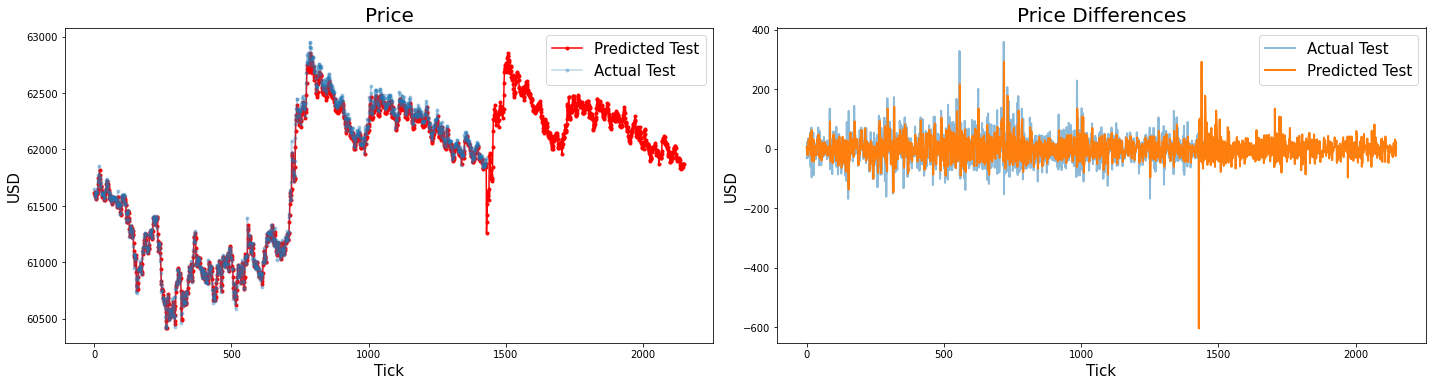

In [30]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot(predicted_btc_test_concatenated, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test', alpha=0.3)
plt.xlabel("Tick", fontsize=15)
plt.ylabel("USD", fontsize=15)
plt.title("Price", fontsize=20)
plt.legend(loc='best', fontsize='15')

plt.subplot(2,2,2)
plt.plot(np.diff(test_actual, axis=0),label='Actual Test', alpha=0.5, linewidth=2)
plt.plot(np.diff(predicted_btc_test_concatenated, axis=0), label='Predicted Test', linewidth=2)
plt.xlabel("Tick", fontsize=15)
plt.ylabel("USD", fontsize=15)
plt.title("Price Differences", fontsize=20)
plt.legend(loc='best', fontsize='15')
plt.tight_layout()

## Create dataframe for our trade positions

In [31]:
df_strategy_actual = pd.DataFrame(test_actual)
df_strategy_predicted = pd.DataFrame(predicted_btc_price_test_data)

df_strategy_actual = df_strategy_actual.rename(columns={0: "close"})
df_strategy_predicted = df_strategy_predicted.rename(columns={0: "close"})

In [32]:
def classify(current, future):
    if future is None:
        return
    """
    Επιστρέφει 1 αν η τιμή στο μέλλον είναι αυξημένη ή
    -1 αν η τιμή στο μέλλον είναι μειωμένη
    """
    if float(future) > float(current):
        return 1
    elif float(future) < float(current):
        return -1

In [33]:
df_strategy_actual['future'] = df_strategy_actual["close"].shift(-1)
df_strategy_predicted['future'] = df_strategy_predicted["close"].shift(-1)
df_strategy_actual['target'] = list(map(classify, df_strategy_actual["close"], df_strategy_actual["future"]))
df_strategy_predicted['target'] = list(map(classify, df_strategy_predicted["close"], df_strategy_predicted["future"]))

frames = [df_strategy_actual, df_strategy_predicted]
result = pd.concat(frames, axis=1, ignore_index=True)
result = result.rename(columns={0: "actual_close", 
                                1:"actual_future_close", 
                                2:"actual_target",
                                3:"predicted_close",
                                4:"predicted_future_close",
                                5:"predicted_target"})
result.dropna(inplace = True)
result["prcnt_change"] = (result['predicted_future_close'] - result['predicted_close'] ) / result['predicted_close']
result.reset_index(inplace=True, drop=True)
result.head(10)

,actual_close,actual_future_close,actual_target,predicted_close,predicted_future_close,predicted_target,prcnt_change
0,61646.29,61614.14,-1.0,61617.648438,61623.113281,1.0,0.000089
1,61614.14,61591.31,-1.0,61623.113281,61609.101562,-1.0,-0.000227
2,61591.31,61614.43,1.0,61609.101562,61588.335938,-1.0,-0.000337
3,61614.43,61582.86,-1.0,61588.335938,61595.628906,1.0,0.000118
4,61582.86,61562.09,-1.0,61595.628906,61580.656250,-1.0,-0.000243
5,61562.09,61589.65,1.0,61580.656250,61559.867188,-1.0,-0.000338
6,61589.65,61624.06,1.0,61559.867188,61569.976562,1.0,0.000164
7,61624.06,61608.43,-1.0,61569.976562,61600.328125,1.0,0.000493
8,61608.43,61620.40,1.0,61600.328125,61603.765625,1.0,0.000056
9,61620.40,61612.92,-1.0,61603.765625,61609.968750,1.0,0.000101


## RRL Stock Trading

In [34]:
def sharpe_ratio(rets):
    return rets.mean() / rets.std()

def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

def returns(Ft, x, delta=0):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

def gradient(x, theta, delta):
    Ft = positions(x, theta)
    R = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2
    
    A = np.mean(R)
    B = np.mean(np.square(R))
    S = A / np.sqrt(B - A ** 2)

    dSdA = S * (1 + S ** 2) / A
    dSdB = -S ** 3 / 2 / A ** 2
    dAdR = 1. / T
    dBdR = 2. / T * R
    
    grad = np.zeros(M + 2)  
    dFpdtheta = np.zeros(M + 2)  
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dSdA * dAdR + dSdB * dBdR[t]) * (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta
        
    return grad, S

def train(x, epochs=2000, M=8, commission=0, learning_rate = 0.3):
    theta = np.random.rand(M + 2)
    sharpes = np.zeros(epochs) 
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta = theta + grad * learning_rate
        sharpes[i] = sharpe
    
    print("finished training")
    return theta, sharpes

In [35]:
rets = btc_input_df['close'].copy().diff()[1:ROWS_OF_DATASET]
x = np.array(rets)
N = TRAIN_DATA_RRL 
x_train = x[:N]
x_test = x[N:]

In [36]:
x_test

array([-58.84,  -9.92,   7.99, ...,  51.76, -20.41,  37.24])

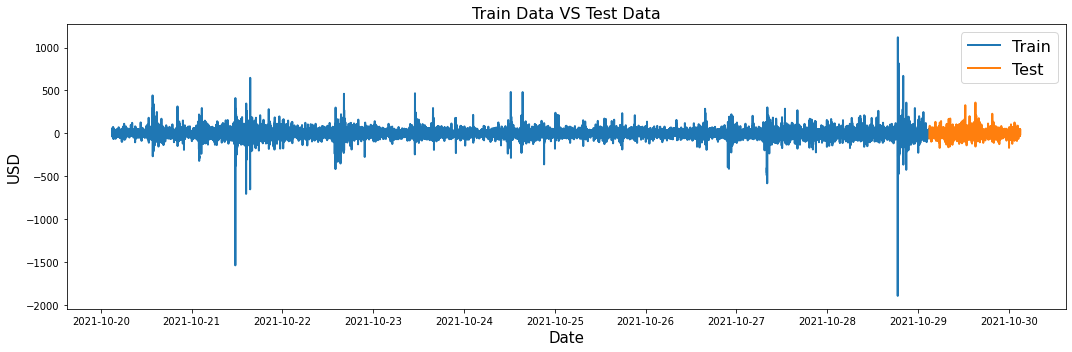

In [37]:
plt.figure(figsize=(15,5))
plt.plot(rets[:N], label='Train', linewidth=2,)
plt.plot(rets[N:], label='Test', linewidth=2,)
plt.ylabel('USD', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.title('Train Data VS Test Data', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()

In [38]:
# # standardizing the values
std = np.std(x_train)
mean = np.mean(x_train)

x_tr = x_train[:]

x_train = (x_train - mean) / std
# x_test = (x_test - mean) / std

# # # for lstm predictions
x_lstm_test = np.diff(predicted_btc_price_test_data)
# x_lstm_test = (x_lstm_test - mean) / std

In [39]:
%%time
np.random.seed(0)
print('start training')
theta, sharpes = train(x_train, epochs=EPOCHS_RRL, M=LOOK_BACK_RRL, commission=0, learning_rate=LEARNING_RATE_RRL)

start training
finished training
Wall time: 7min 22s


Sharpe ratio: 0.04920700198651913


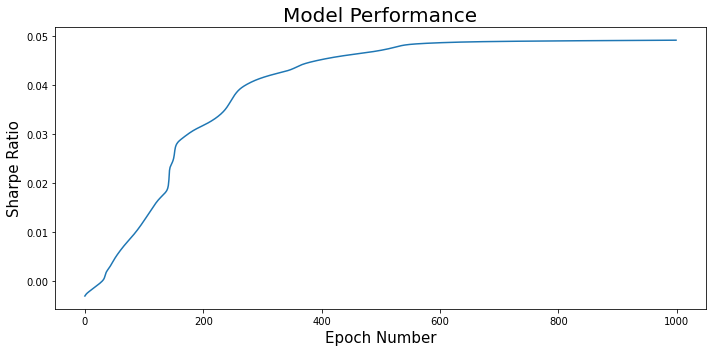

In [40]:
plt.figure(figsize=(10,5))
plt.title("Model Performance", fontsize=20)
plt.plot(sharpes)
plt.xlabel('Epoch Number', fontsize=15)
plt.ylabel('Sharpe Ratio', fontsize=15)
plt.tight_layout()
print(f"Sharpe ratio: {sharpes[-1]}")

In [41]:
x_train = x_tr[:]
train_returns = returns(positions(x_train, theta), x_train)
test_returns = returns(positions(x_test, theta), x_test)

train_positions = positions(x_train, theta)
test_positions = positions(x_test, theta)

lstm_returns= returns(positions(x_lstm_test, theta), x_test[:len(x_lstm_test)-1])
lstm_positions = positions(x_lstm_test, theta)

RL model on train data: 37356.43839822484 USD
Buy and Hold - train Data: -2158.1200000000026 USD
RL model on test data: 4184.853535420538 USD
RL model on lstm predictions: 20404.376074149382 USD
Buy and Hold - test data: 254.74000000000524 USD


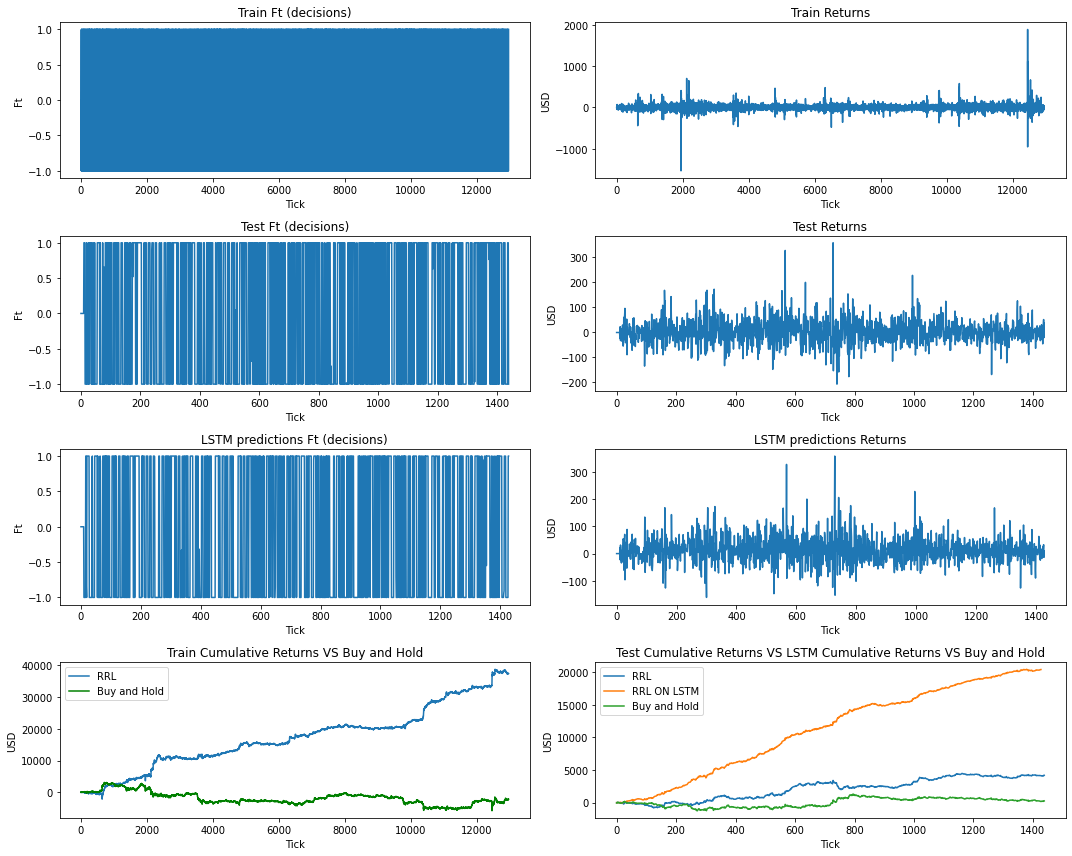

In [42]:
plt.figure(figsize=(15,12))

plt.subplot(4,2,1)
plt.xlabel("Tick")
plt.ylabel("Ft")
plt.plot(train_positions)
plt.title("Train Ft (decisions)")

plt.subplot(4,2,2)
plt.xlabel("Tick")
plt.ylabel('USD')
plt.plot(train_returns)
plt.title("Train Returns")

plt.subplot(4,2,3)
plt.xlabel("Tick")
plt.ylabel("Ft")
plt.plot(test_positions)
plt.title("Test Ft (decisions)")

plt.subplot(4,2,4)
plt.xlabel("Tick")
plt.ylabel('USD')
plt.plot(test_returns)
plt.title("Test Returns")

plt.subplot(4,2,5)
plt.xlabel("Tick")
plt.ylabel('Ft')
plt.plot(lstm_positions)
plt.title("LSTM predictions Ft (decisions)")

plt.subplot(4,2,6)
plt.xlabel("Tick")
plt.ylabel('USD')
plt.plot(lstm_returns)
plt.title("LSTM predictions Returns")

plt.subplot(4,2,7)
plt.xlabel("Tick")
plt.ylabel('USD')
plt.plot(train_returns.cumsum(), label="RRL")

plt.subplot(4,2,7)
plt.xlabel("Tick")
plt.ylabel('USD')
plt.plot(x_train.cumsum(), color="green", label="Buy and Hold")
plt.title("Train Cumulative Returns VS Buy and Hold")
plt.legend()

plt.subplot(4,2,8)
plt.xlabel("Tick")
plt.ylabel('USD')
plt.plot(test_returns.cumsum(), label= "RRL")

plt.subplot(4,2,8)
plt.xlabel("Tick")
plt.plot(lstm_returns.cumsum(), label= "RRL ON LSTM")

plt.subplot(4,2,8)
plt.xlabel("Tick")
plt.plot(x_test.cumsum(), label= "Buy and Hold")
plt.title("Test Cumulative Returns VS LSTM Cumulative Returns VS Buy and Hold")
plt.legend(loc='best')

plt.tight_layout()

print(f"RL model on train data: {train_returns.cumsum()[-1]} USD" )
print(f"Buy and Hold - train Data: {x_train.cumsum()[-1]} USD")
print(f"RL model on test data: {test_returns.cumsum()[-1]} USD")
print(f"RL model on lstm predictions: {lstm_returns.cumsum()[-1]} USD")
print(f"Buy and Hold - test data: {x_test.cumsum()[-1]} USD")

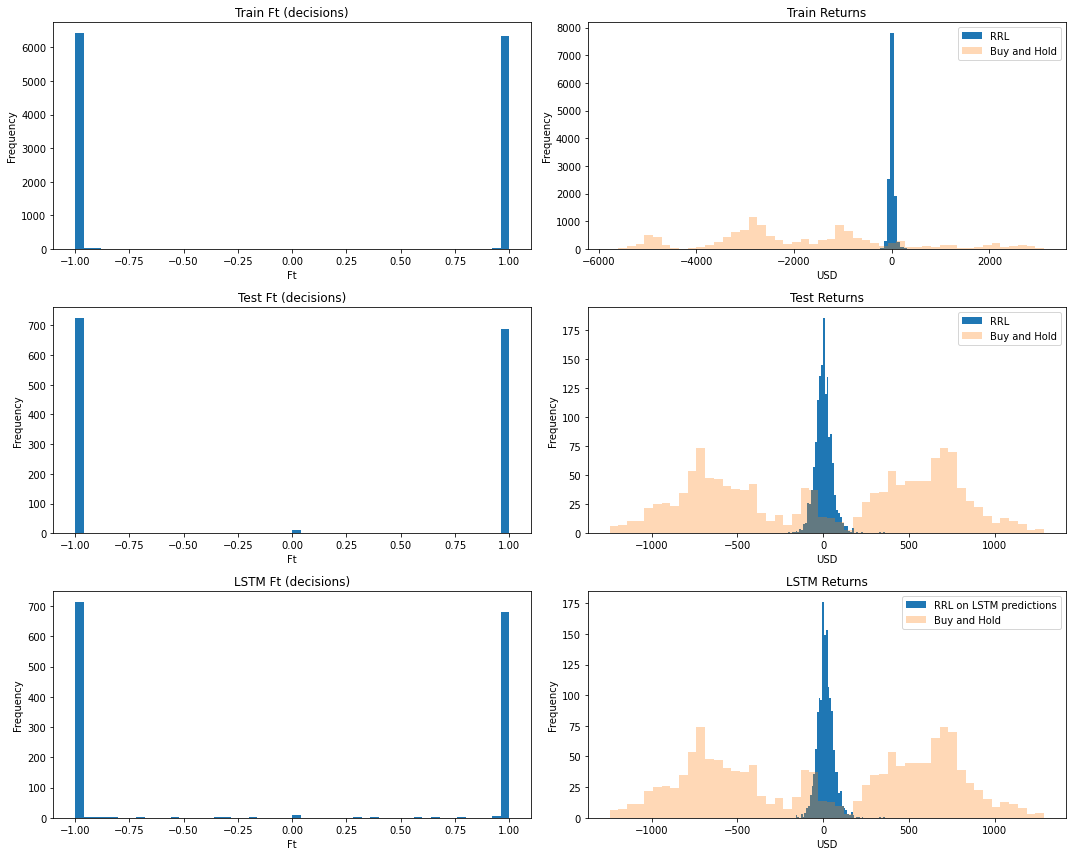

In [43]:
plt.figure(figsize=(15,12))
HIST_BINS = 50

plt.subplot(3,2,1)
plt.ylabel("Frequency", )
plt.xlabel("Ft")
plt.hist(train_positions, bins=HIST_BINS)
plt.title("Train Ft (decisions)")

plt.subplot(3,2,2)
plt.ylabel("Frequency", )
plt.xlabel("USD")
plt.hist(train_returns, bins=HIST_BINS, label="RRL")
plt.hist(x_train.cumsum(), bins=HIST_BINS, alpha=0.3, label="Buy and Hold")
plt.title("Train Returns")
plt.legend()

plt.subplot(3,2,3)
plt.xlabel("Ft")
plt.ylabel("Frequency", )
plt.hist(test_positions, bins=HIST_BINS)
plt.title("Test Ft (decisions)")

plt.subplot(3,2,4)
plt.xlabel("USD")
plt.ylabel("Frequency",)
plt.hist(test_returns, bins=HIST_BINS, label="RRL")
plt.hist(x_test.cumsum(), bins=HIST_BINS, alpha=0.3, label="Buy and Hold")
plt.title("Test Returns")
plt.legend()

plt.subplot(3,2,5)
plt.xlabel("Ft")
plt.ylabel("Frequency",)
plt.hist(lstm_positions, bins=HIST_BINS)
plt.title("LSTM Ft (decisions)")

plt.subplot(3,2,6)
plt.ylabel("Frequency", )
plt.xlabel("USD")
plt.hist(lstm_returns, bins=HIST_BINS, label="RRL on LSTM predictions")
plt.hist(x_test.cumsum(), bins=HIST_BINS, alpha=0.3, label="Buy and Hold")
plt.title("LSTM Returns")
plt.legend()

plt.tight_layout()

## Functions for Trading

In [44]:
def trade_long(positions, stock_prices, usd=5000, btc=0, fee=0):
    """
    Αγοράζουμε για όσο προβλέπουμε πως θα ανέβει η τιμή και τα πουλάμε όλα 
    όταν προβλέπουμε πως θα πέσει η τιμή
    """
    cnt = 0
    total = []
    total.append(usd + btc * stock_prices[0])
    print(f"Start with: {total[0]} USD")
    for index in range(len(stock_prices) - 1): 

        # αγοράζουμε
        if positions[index] > 0 and usd > 0:
            buy = positions[index] * usd
            btc = buy / stock_prices[index] + btc
            usd = usd - buy - (fee * buy)
            cnt += 1
            total.append(usd + btc * stock_prices.iloc[index])
            continue

        # πουλάμε 
        if positions[index] < 0 and btc > 0: 
            usd = btc * stock_prices[index] + usd - (fee * btc)
            btc = 0
            cnt += 1
            total.append(usd + btc * stock_prices.iloc[index])
            continue
    
    print(f"End with: {total[-1]} USD\nProfit: {total[-1] - total[0]} USD\n# of trades: {cnt}\n")
    return total

def trade_short(positions, stock_prices, usd=0, btc=2, fee=0):
    """
    Στην συγκεκριμένη στρατηγική πουλάμε όλα τα bitcoin που έχουμε,
    και αγοράζουμε την ίδια ποσότητα που πουλήσαμε όταν προβλέπουμε πως θα ξαναανέβει η τιμή
    """
    cnt = 0
    total = []
    total.append(usd + btc * stock_prices[0])
    short = False
    first_btc = copy.deepcopy(btc)
    print(f"Start with: {total[0]} USD")
    for index in range(len(stock_prices) - 1): 
        # αγοράζουμε
        if positions[index] > 0  and usd > 0 and usd >= (first_btc) * stock_prices[index]:
            buy = copy.deepcopy(first_btc)
            btc = buy / stock_prices[index] + btc
            usd = usd - buy - (fee * buy)
            cnt += 1
            total.append(usd + btc * stock_prices.iloc[index])
            short = False
            continue

        # πουλάμε 
        if positions[index] < 0 and btc > first_btc - (first_btc / 2):  
            first_btc = copy.deepcopy(btc)
            usd = btc * stock_prices[index] + usd - (fee * btc)
            btc = 0
            cnt += 1
            total.append(usd + btc * stock_prices.iloc[index])
            short = True
            continue
        
    print(f"End with: {total[-1]} USD\nProfit: {total[-1] - total[0]} USD\n# of trades: {cnt}\n")
    
    return total

In [45]:
result['prcnt_change'].agg(['min', 'max', 'mean'])

min    -0.002422
max     0.004736
mean    0.000003
Name: prcnt_change, dtype: float32

---RRL LONG---
Start with: 5000.0 USD
End with: 5137.768016974763 USD
Profit: 137.76801697476276 USD
# of trades: 482

---RRL ON LSTM LONG---
Start with: 5000.0 USD
End with: 5100.497771520955 USD
Profit: 100.49777152095521 USD
# of trades: 403

---LSTM LONG---
Start with: 5000.0 USD
End with: 4996.220618256196 USD
Profit: -3.7793817438041515 USD
# of trades: 964

---------------------------------------------------
---RRL SHORT---
Start with: 123292.58 USD
End with: 123543.42966657958 USD
Profit: 250.84966657958284 USD
# of trades: 333

---RRL ON LSTM SHORT---
Start with: 123292.58 USD
End with: 123228.24932947419 USD
Profit: -64.33067052581464 USD
# of trades: 317

---LSTM SHORT---
Start with: 123292.58 USD
End with: 123230.46818617811 USD
Profit: -62.11181382188806 USD
# of trades: 317



Text(0.5, 1.0, 'PORTFOLIO - SHORT')

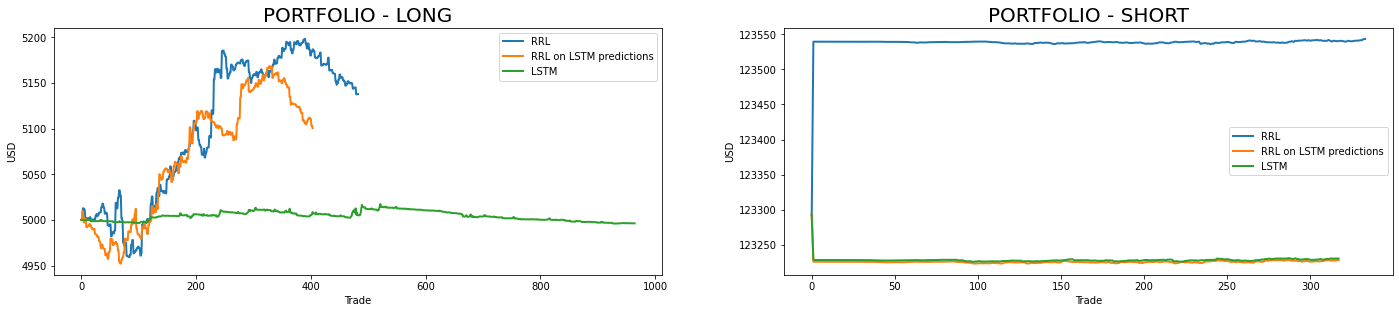

In [46]:
print("---RRL LONG---")
total_rrl_long = trade_long(positions(x_test[:], theta), result['actual_close'].copy())
print("---RRL ON LSTM LONG---")
total_rrl_lstm_long = trade_long(positions(x_lstm_test, theta), result['actual_close'].copy())
print("---LSTM LONG---")
total_lstm_long = trade_long(result['prcnt_change'] * 100, result['actual_close'].copy())
print("---------------------------------------------------")
print("---RRL SHORT---")
total_rrl_short = trade_short(positions(x_test[:], theta), result['actual_close'].copy())
print("---RRL ON LSTM SHORT---")
total_rrl_lstm_short = trade_short(positions(x_lstm_test, theta), result['actual_close'].copy())
print("---LSTM SHORT---")
total_lstm_short = trade_short(result['prcnt_change'], result['actual_close'].copy())

plt.figure(figsize=(24,10))
plt.subplot(2,2,1)
plt.plot(total_rrl_long, label="RRL", linewidth=2)
plt.plot(total_rrl_lstm_long, label="RRL on LSTM predictions", linewidth=2)
plt.plot(total_lstm_long, label="LSTM", linewidth=2)
plt.xlabel('Trade')
plt.ylabel('USD')
plt.legend(loc='best')
plt.title("PORTFOLIO - LONG", fontsize=20)

plt.subplot(2,2,2)
plt.plot(total_rrl_short, label="RRL", linewidth=2)
plt.plot(total_rrl_lstm_short, label="RRL on LSTM predictions", linewidth=2)
plt.plot(total_lstm_short, label="LSTM", linewidth=2)
plt.xlabel('Trade')
plt.ylabel('USD')
plt.legend()
plt.title("PORTFOLIO - SHORT", fontsize=20)